### Drug-resistant cells
- Cell's sensitivity to drugs exists on a spectrum
- Binary classification into sensitive v.s. resistant cells is still possible

In [1]:
library(dplyr)
library(tibble)
library(reshape2)

## Plotting
library(ggplot2)
library(cowplot)
library(RColorBrewer)
library(UpSetR)

library(xtable)

theme_set(theme_bw())


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [2]:
source("../R/calc.R")
source("../R/misc.R")
source("../R/normalise.R")
source("../R/plot.R")
source("../R/predict.R")
source("../R/subset.R")
source("../R/utils.R")

## Import data

In [5]:
### ANNOTATIONS
METADATA_SID <- "../data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../data/GSE67684/processed/metadata/pid-metadata_v7.tsv"

metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')
metadata_pid$label <- as.factor(metadata_pid$label)

### DATA
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [6]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

## Batch effect features

In [7]:
batch_ps <- identify_batch_features(yeoh, metadata, method = 'aov')
length(batch_ps)

[1] "No. of NaNs = 0"


[1] 2565

In [8]:
batch_allps <- identify_batch_features(yeoh_allps, metadata, method = 'aov')
length(batch_allps)

[1] "No. of NaNs = 0"


[1] 7504

## Prediction

In [ ]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_obj1 <- lapply(
  list_X_subtypes7,
  predict_pipeline_v2,
  X_normal, metadata, metadata_pid,
  batch_genes = NULL,
  include_tp2 = F
)
names(list_obj1) <- subtypes7

In [ ]:
list_X_y <- lapply(list_obj1, function(obj) obj$X_y)
boxplots <- lapply(list_X_y, plot_boxplots)

# for (subtype in subtypes7) {
#   file <- sprintf("~/Dropbox/tmp/features-%s.pdf", subtype)
#   ggsave(file, boxplots[[subtype]], width = 9, height = 2.5)
# }

### Import drug sensitive genes

In [157]:
FILE1 <- "../data/other_methods/holleman_2004/asparaginase.txt"
FILE2 <- "../data/other_methods/holleman_2004/daunorubicin.txt"
FILE3 <- "../data/other_methods/holleman_2004/prednisolone.txt"
FILE4 <- "../data/other_methods/holleman_2004/vincristine.txt"

asp <- read.table(
  FILE1, header = TRUE, sep = "\t",
  stringsAsFactors = FALSE, na.strings = c("NA", "")
)
dau <- read.table(
  FILE2, header = TRUE, sep = "\t",
  stringsAsFactors = FALSE, na.strings = c("NA", "")
)
pred <- read.table(
  FILE3, header = TRUE, sep = "\t",
  stringsAsFactors = FALSE, na.strings = c("NA", "")
)
vinc <- read.table(
  FILE4, header = TRUE, sep = "\t",
  stringsAsFactors = FALSE, na.strings = c("NA", "")
)

### Import Rhein

In [158]:
FILE <- "../data/other_methods/rhein_2007.txt"
rhein <- read.table(
  FILE, header = TRUE, sep = "\t",
  quote = '"', stringsAsFactors = FALSE,
  na.strings = c("NA", "")
)

### Import differential genes

In [159]:
files <- list.files("../tmp", "response", full.names = TRUE)
differential_probesets <- lapply(files, readLines)
files1 <- substring(files, 17)
files1 <- gsub(".txt", "", files1)
names(differential_probesets) <- files1

### Import SPS

In [160]:
FILE <- "../data/goh_2019/goh_signatures.tsv"
sps_genes <- read.table(FILE, sep = "\t", header = T)

FILE <- "../../info/DAVID/gene_id/ENTREZ_GENE_ID2OFFICIAL_GENE_SYMBOL.txt"
entrez_gene_mapping <- read.table(
  FILE, sep = "\t", row.names = 1, stringsAsFactors = FALSE
)
# Convert entrez to gene symbols
sps_symbols <- entrez_gene_mapping[as.character(sps_genes$ENTREZ_GENE_ID), ]

In [21]:
# FILE <- "../../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
# symbol_mapping <- affy2id(yeoh_allps, FILE, ret.annot = TRUE)

No. of probesets with no ID removed = 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762


In [161]:
# Convert affy to gene symbols
differential_symbols <- lapply(differential_probesets, function(x) symbol_mapping[x])
# Remove missing values and duplicates in gene symbols
differential_symbols <- lapply(differential_symbols, function(x) unique(x[!is.na(x)]))

In [162]:
# Take first symbol of genes with multiple symbols
differential_symbols1 <- list()
for (symbols in differential_symbols) {
  idx <- grepl("///", symbols)
  
  if (sum(idx) > 1) {
    first_symbol <- gsub(" ///.*", "", symbols[idx])
    symbols[idx] <- first_symbol
  }
  differential_symbols1 <- c(differential_symbols1, list(symbols))
}
names(differential_symbols1) <- subtypes7

In [163]:
# Remove missing values and duplicates in gene symbols
drug_symbols <- list(
  asp = asp$gene_symbol, dau = dau$gene_symbol,
  pred = pred$gene_symbol, vinc = vinc$gene_symbol
)
drug_symbols <- lapply(drug_symbols, function(x) unique(x[!is.na(x)]))
rhein_symbols <- unique(rhein$gene_symbol[!is.na(rhein$gene_symbol)])

In [169]:
list_all_symbols <- c(
  differential_symbols1, drug_symbols,
  rhein = list(rhein_symbols), sps = list(sps_symbols)
)

In [176]:
all_symbols <- unname(do.call(c, list_all_symbols))

In [181]:
symbols_fltr <- all_symbols[all_symbols %in% rownames(yeoh_symbol)]

### Upset plot
- Drug probesets have little overlap with others
- Rhein probesets overlap with differential probesets
- Overlap of SPS genes and Rhein (2007)

#### Probe sets

In [164]:
drug_probesets <- list(
  asp = asp$probe_id, dau = dau$probe_id,
  pred = pred$probe_id, vinc = vinc$probe_id
)
response_probesets <- c(differential_probesets, rhein = list(rhein$probe_id))

In [138]:
# pdf("~/Dropbox/tmp/venn-differential_ps.pdf", width = 6, height = 5)
# upset(fromList(response_probesets1), nsets = 10, order.by = "freq")
# dev.off()

ERROR: Error in unlist(input): object 'response_probesets1' not found


#### Gene symbols

In [136]:
list_symbols <- c(drug_symbols, sps = list(sps_symbols))

In [137]:
pdf("~/Dropbox/tmp/venn-drug_genes.pdf", width = 6, height = 6)
upset(fromList(list_symbols), nsets = 15, order.by = "freq")
dev.off()

png 
  2

### Feature selection

#### Only use differential probesets that are also in Rhein (reproducible)

In [165]:
reproducible_ps <- lapply(differential_probesets, function(x) intersect(x, rhein$probe_id))

In [166]:
X_normal <- yeoh_allps[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh_allps[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
names(list_X_subtypes7) <- subtypes7

In [167]:
list_obj1 <- list()
for (subtype in subtypes7) {
  obj <- predict_pipeline_v2(
    list_X_subtypes7[[subtype]],
    class_genes = reproducible_ps[[subtype]],
    X_normal = X_normal,
    metadata_sid = metadata,
    metadata_pid = metadata_pid,
    batch_genes = NULL,
    include_tp2 = F
  )
  list_obj1 <- c(list_obj1, list(obj))
}

No. of features selected = 6
No. of final genes = 6
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 35
No. of final genes = 35
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 33
No. of final genes = 33
[1] "NO. OF SAMPLES IN CENTROID: 31"
[1] "No. of remission samples in training set = 31"
No. of features selected = 33
No. of final genes = 33
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "No. of remission samples in training set = 3"
No. of features selected = 61
No. of final genes = 61
[1] "NO. OF SAMPLES IN CENTROID: 63"
[1] "No. of remission samples in training set = 63"
No. of features selected = 15
No. of final genes = 15
[1] "NO. OF SAMPLES IN CENTROID: 8"
[1] "No. of remission samples in training set = 8"
No. of features selected = 48
No. of final genes = 48
[1] "NO. OF SAMPLES IN CENTROID: 29"
[1] "No. of remission samples in training set = 29"


In [168]:
list_X_y <- lapply(list_obj1, function(obj) obj$X_y)
boxplots <- lapply(list_X_y, plot_boxplots)
names(boxplots) <- subtypes7

for (subtype in subtypes7) {
  file <- sprintf("~/Dropbox/tmp/reproducible-%s.pdf", subtype)
  ggsave(file, boxplots[[subtype]], width = 9, height = 2.5)
}

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message 

#### Genes both in SPS and Rhein

In [145]:
sps_rhein_symbols <- intersect(sps_symbols, rhein_symbols)

In [142]:
FILE <- "../../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
yeoh_symbol <- affy2id(yeoh_allps, FILE)

No. of probesets with no ID removed = 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762


In [178]:
X1_normal <- yeoh_symbol[, sid_normal]
list_X1_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh_symbol[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)

In [186]:
list_obj2 <- lapply(
  list_X1_subtypes7,
  predict_pipeline_v2,
  X1_normal, metadata, metadata_pid,
  batch_genes = NULL,
  class_genes = symbols_fltr,
  include_tp2 = F
)
names(list_obj2) <- subtypes7

No. of features selected = 2100
No. of final genes = 2100
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 2100
No. of final genes = 2100
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 2100
No. of final genes = 2100
[1] "NO. OF SAMPLES IN CENTROID: 31"
[1] "No. of remission samples in training set = 31"
No. of features selected = 2100
No. of final genes = 2100
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "No. of remission samples in training set = 3"
No. of features selected = 2100
No. of final genes = 2100
[1] "NO. OF SAMPLES IN CENTROID: 63"
[1] "No. of remission samples in training set = 63"
No. of features selected = 2100
No. of final genes = 2100
[1] "NO. OF SAMPLES IN CENTROID: 8"
[1] "No. of remission samples in training set = 8"
No. of features selected = 2100
No. of final genes = 2100
[1] "NO. OF SAMPLES IN CENTROID: 29"
[1] "No. of remission samples i

In [187]:
list_X_y2 <- lapply(list_obj2, function(obj) obj$X_y)
boxplots <- lapply(list_X_y2, plot_boxplots)

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message 

In [188]:
for (subtype in subtypes7) {
  file <- sprintf("~/Dropbox/tmp/all_symbols-%s.pdf", subtype)
  ggsave(file, boxplots[[subtype]], width = 9, height = 2.5)
}

### Multiple models: 4 sets of drug genes

In [191]:
X_all_normal <- yeoh_allps[, sid_normal]
list_X_all_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh_allps[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)

In [193]:
asp_predictions <- lapply(
  list_X_all_subtypes7,
  predict_pipeline_v2,
  X_all_normal,
  metadata, metadata_pid,
  class_genes = asp$probe_id,
  batch_genes = NULL,
  include_tp2 = F
)
names(asp_predictions) <- subtypes7

No. of features selected = 52
No. of final genes = 52
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 52
No. of final genes = 52
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 52
No. of final genes = 52
[1] "NO. OF SAMPLES IN CENTROID: 31"
[1] "No. of remission samples in training set = 31"
No. of features selected = 52
No. of final genes = 52
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "No. of remission samples in training set = 3"
No. of features selected = 52
No. of final genes = 52
[1] "NO. OF SAMPLES IN CENTROID: 63"
[1] "No. of remission samples in training set = 63"
No. of features selected = 52
No. of final genes = 52
[1] "NO. OF SAMPLES IN CENTROID: 8"
[1] "No. of remission samples in training set = 8"
No. of features selected = 52
No. of final genes = 52
[1] "NO. OF SAMPLES IN CENTROID: 29"
[1] "No. of remission samples in training set = 29"


In [194]:
pred_predictions <- lapply(
  list_X_all_subtypes7,
  predict_pipeline_v2,
  X_all_normal,
  metadata, metadata_pid,
  class_genes = pred$probe_id,
  batch_genes = NULL,
  include_tp2 = F
)
names(pred_predictions) <- subtypes7

No. of features selected = 32
No. of final genes = 32
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 32
No. of final genes = 32
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 32
No. of final genes = 32
[1] "NO. OF SAMPLES IN CENTROID: 31"
[1] "No. of remission samples in training set = 31"
No. of features selected = 32
No. of final genes = 32
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "No. of remission samples in training set = 3"
No. of features selected = 32
No. of final genes = 32
[1] "NO. OF SAMPLES IN CENTROID: 63"
[1] "No. of remission samples in training set = 63"
No. of features selected = 32
No. of final genes = 32
[1] "NO. OF SAMPLES IN CENTROID: 8"
[1] "No. of remission samples in training set = 8"
No. of features selected = 32
No. of final genes = 32
[1] "NO. OF SAMPLES IN CENTROID: 29"
[1] "No. of remission samples in training set = 29"


In [196]:
dau_predictions <- lapply(
  list_X_all_subtypes7,
  predict_pipeline_v2,
  X_all_normal,
  metadata, metadata_pid,
  class_genes = dau$probe_id,
  batch_genes = NULL,
  include_tp2 = F
)
names(dau_predictions) <- subtypes7

No. of features selected = 15
No. of final genes = 15
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 15
No. of final genes = 15
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 15
No. of final genes = 15
[1] "NO. OF SAMPLES IN CENTROID: 31"
[1] "No. of remission samples in training set = 31"
No. of features selected = 15
No. of final genes = 15
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "No. of remission samples in training set = 3"
No. of features selected = 15
No. of final genes = 15
[1] "NO. OF SAMPLES IN CENTROID: 63"
[1] "No. of remission samples in training set = 63"
No. of features selected = 15
No. of final genes = 15
[1] "NO. OF SAMPLES IN CENTROID: 8"
[1] "No. of remission samples in training set = 8"
No. of features selected = 15
No. of final genes = 15
[1] "NO. OF SAMPLES IN CENTROID: 29"
[1] "No. of remission samples in training set = 29"


In [197]:
vinc_predictions <- lapply(
  list_X_all_subtypes7,
  predict_pipeline_v2,
  X_all_normal,
  metadata, metadata_pid,
  class_genes = vinc$probe_id,
  batch_genes = NULL,
  include_tp2 = F
)
names(vinc_predictions) <- subtypes7

No. of features selected = 54
No. of final genes = 54
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 54
No. of final genes = 54
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
No. of features selected = 54
No. of final genes = 54
[1] "NO. OF SAMPLES IN CENTROID: 31"
[1] "No. of remission samples in training set = 31"
No. of features selected = 54
No. of final genes = 54
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "No. of remission samples in training set = 3"
No. of features selected = 54
No. of final genes = 54
[1] "NO. OF SAMPLES IN CENTROID: 63"
[1] "No. of remission samples in training set = 63"
No. of features selected = 54
No. of final genes = 54
[1] "NO. OF SAMPLES IN CENTROID: 8"
[1] "No. of remission samples in training set = 8"
No. of features selected = 54
No. of final genes = 54
[1] "NO. OF SAMPLES IN CENTROID: 29"
[1] "No. of remission samples in training set = 29"


In [210]:
multmodel_p_remission <- mapply(
  function(o1, o2, o3, o4) cbind(
    o1$p_remission_xi[1:3], o2$p_remission_xi[1:3],
    o3$p_remission_xi[1:3], o4$p_remission_xi[1:3]
  ),
  asp_predictions, dau_predictions,
  pred_predictions, vinc_predictions,
  SIMPLIFY = FALSE
)

In [213]:
multmodel_proba <- lapply(multmodel_p_remission, rowMeans)
proba <- do.call(c, unname(multmodel_proba))

In [228]:
proba_y <- data.frame(
  p = proba,
  metadata_pid[names(proba), c("subtype", "label", "treatment")]
)
proba_y$label <- as.factor(proba_y$label)

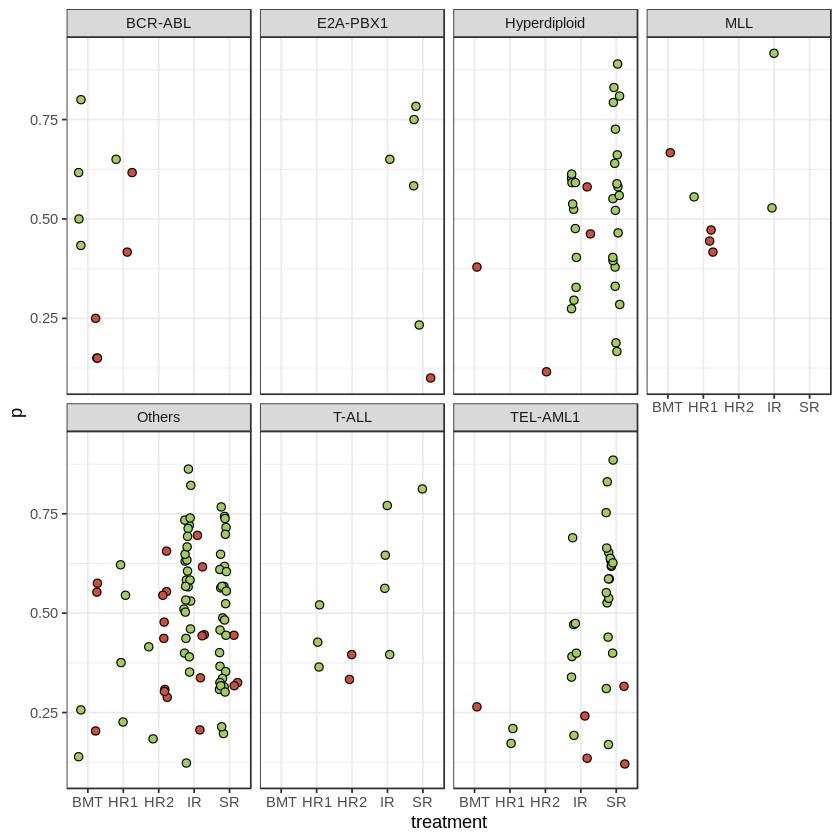

In [240]:
ax_multmodel <- ggplot(
  proba_y,
  aes(x = treatment, y = p, fill = label)
) +
  facet_wrap(~subtype, nrow = 2) +
  geom_point(
    position = position_jitterdodge(),
    pch = 21, cex = 2, show.legend = FALSE
  ) +
  scale_fill_manual(values = COL_LABEL)

ax_multmodel
# ggsave("~/Dropbox/tmp/proba-multiple_model.pdf", ax_multmodel, width = 7, height = 5)

In [239]:
multmodel_p_remission

,p_erm1_ratio2,p_l2norm_ratio2,p_angle_d0d8_d0normal,p_erm1_ratio2,p_l2norm_ratio2,p_angle_d0d8_d0normal,p_erm1_ratio2,p_l2norm_ratio2,p_angle_d0d8_d0normal,p_erm1_ratio2,p_l2norm_ratio2,p_angle_d0d8_d0normal
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P053,0.6,0.6,0.8,0.2,0.2,0.2,0.6,0.2,0.2,0.4,0.8,0.4
P054,0.2,0.4,0.6,0.8,0.8,0.6,0.4,0.6,0.4,1.0,1.0,1.0
P055,0.4,0.2,0.2,1.0,1.0,1.0,0.8,0.4,0.6,0.6,0.4,0.8
P056,0.4,0.0,0.0,0.8,1.0,1.0,0.8,0.4,0.2,1.0,0.8,1.0
P057,0.0,0.2,0.0,0.0,0.2,0.0,0.6,0.2,0.2,0.2,0.0,0.2
P134,0.6,0.2,0.8,0.2,0.8,0.6,0.6,0.2,0.2,0.4,0.0,0.4
P152,0.0,0.2,0.0,0.0,0.8,0.6,0.4,0.4,0.2,0.2,0.0,0.2
P170,0.8,0.8,0.4,0.4,0.6,0.4,0.2,1.0,0.8,0.2,0.2,0.2
P175,1.0,1.0,1.0,0.6,0.4,0.8,1.0,0.8,1.0,0.8,0.6,0.6
